In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests

In [67]:
no_pages = 75
def get_data(pageNo):  
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

    r = requests.get('https://www.flipkart.com/vivo-y50-pearl-white-128-gb/product-reviews/itmd0dcc06ffbe06?pid=MOBFSCFZBKFSWGMB&lid=LSTMOBFSCFZBKFSWGMB9DDTP8&marketplace=FLIPKART&page='+str(pageNo), headers=headers)#, proxies=proxies)
    #print(r)
    content = r.content
    soup = BeautifulSoup(content)
    #print(soup.prettify())
    alls = []
    for d in soup.findAll('div', attrs={'class':'_27M-vq'}):
        UserName = d.find('div', attrs={'class':'row _3n8db9'})
        Comment = d.find('p', attrs={'class':'_2-N8zT'})
        star = d.find('div', attrs={'class':'_3LWZlK _1BLPMq'})
        ReviewSentence = d.find('div', attrs={'class':'t-ZTKy'})
        Likes = d.find('div', attrs={'class':'_1LmwT9'})
        Dislikes = d.find('div', attrs={'class':'_1LmwT9 pkR4jH'})

        all1=[]

        if UserName is not None:
            all1.append(UserName.text)
        else:
            all1.append('Unknown-User')
            
        if Comment is not None:
            all1.append(Comment.text)
        else:
            all1.append("No Comments")

        if star is not None:
            all1.append(star.text)
        else:    
                all1.append('0')    

        if ReviewSentence is not None:
            all1.append(ReviewSentence.text)
        else:
            all1.append('No Reviews')     

        if Likes is not None:
            all1.append(Likes.text)
        else:
            all1.append('0')
            
        if Dislikes is not None:
            all1.append(Dislikes.text)
        else:
            all1.append('0')
            
        alls.append(all1)    
    return alls

In [68]:
results = []
for i in range(1, no_pages+1):
    results.append(get_data(i))
    flatten = lambda l: [item for sublist in l for item in sublist]
    #print('-------------------------------- \n',results)
    df = pd.DataFrame(flatten(results),columns=['User','Comment','Star','ReviewSentence', 'Likes','Dislikes'])
    #print('-------------------------------------------- /n',df)
    df.to_csv('mobile_review.csv', index=False, encoding='utf-8')

In [69]:
df = pd.read_csv("mobile_review.csv")
df.shape

(750, 6)

In [70]:
df_noComment=df[df['Comment']=='No Comments']
df_noComment.shape

(0, 6)

In [71]:
df_noReview=df[df['ReviewSentence']=='No Reviews']
df_noReview.shape

(0, 6)

In [72]:
df['UserName'] = df['User'].apply(lambda x: x.split()[0])
df["ReviewSentence"] = df["ReviewSentence"].str.replace('READ MORE', '')

In [73]:
df.head()

,User,Comment,Star,ReviewSentence,Likes,Dislikes,UserName
0,"Ganesh GandhiCertified Buyer, Villupuram5 mont...",Mind-blowing purchase,5,Value for money. Front and back Cameras are g...,508,119,Ganesh
1,"ShreeksCertified Buyer, Bangalore9 months ago2...",Phones with 4GB and half priced are much better..,0,"After using Zenfone 2 laser, Zenfone 3 Laser, ...",2294,919,ShreeksCertified
2,"Ajay PadmaCertified Buyer, Pune5 months ago36...",Fabulous!,5,Nice clearity owsm,366,38,Ajay
3,"pramod pramodCertified Buyer, East Godavari Di...",Best in the market!,5,Very nice,631,99,pramod
4,"Aftab HCertified Buyer, Tiruppur8 months ago15...",Perfect product!,5,beautyful full and best quality 😘😍,1598,302,Aftab


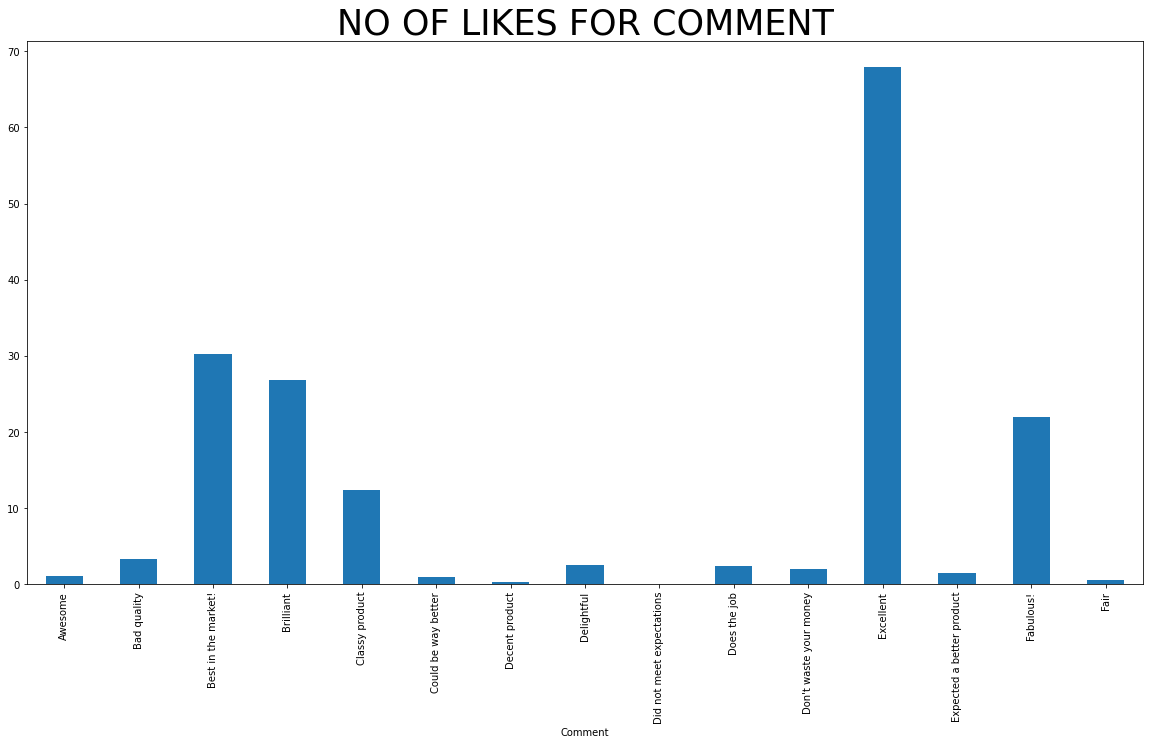

In [98]:
plt.figure(figsize=(20,10))
df.groupby('Comment')['Likes'].mean().head(15).plot(kind='bar')
plt.title('NO OF LIKES FOR COMMENT', fontsize = 35)
plt.show()

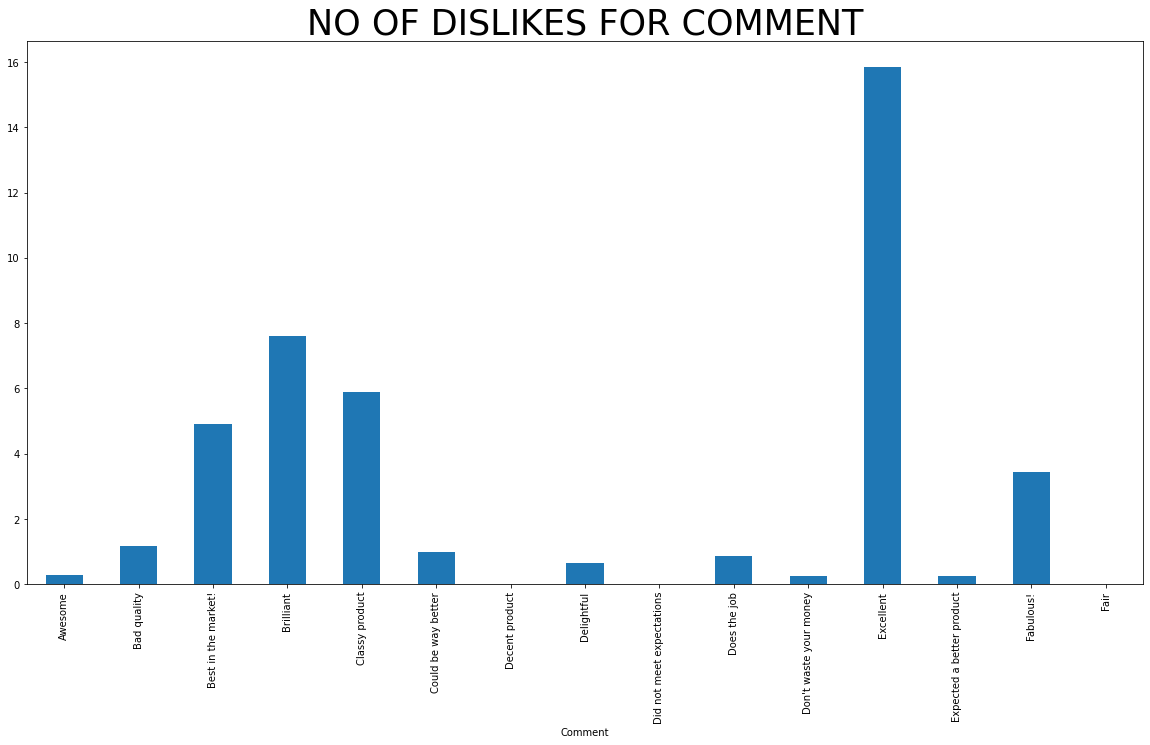

In [99]:
plt.figure(figsize=(20,10))
df.groupby('Comment')['Dislikes'].mean().head(15).plot(kind='bar')
plt.title('NO OF DISLIKES FOR COMMENT', fontsize = 35)
plt.show()

In [101]:
df_Comment_Likes = df.groupby('Comment', as_index=False).agg({"Likes": "sum"})
df_Comment_Likes.head()

,Comment,Likes
0,Awesome,30
1,Bad quality,20
2,Best in the market!,696
3,Brilliant,1099
4,Classy product,309


In [102]:
df_Comment_Dislikes = df.groupby('Comment', as_index=False).agg({"Dislikes": "sum"})
df_Comment_Dislikes.head()

,Comment,Dislikes
0,Awesome,8
1,Bad quality,7
2,Best in the market!,113
3,Brilliant,312
4,Classy product,147


(0.0, 100.0, 0.0, 100.0)

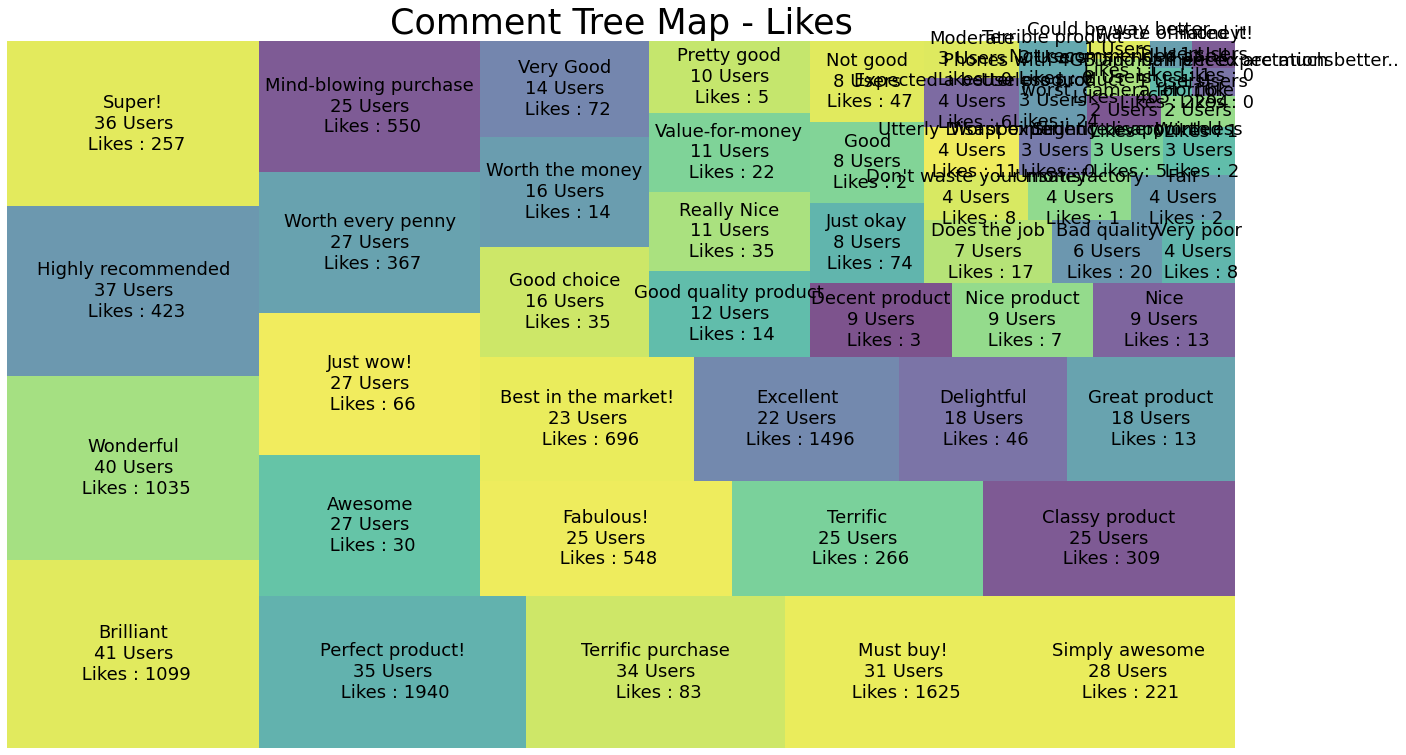

In [110]:
# Brands sorted by number of item
comments = pd.DataFrame(df.Comment.value_counts())
comments.reset_index(level = 0, inplace=True)
comments = comments.sort_values(by='Comment', ascending = False)
comments.columns = ('Comment', 'number_of_item')

# Brands by price
group = df.groupby(df.Comment)
comment_likes = pd.DataFrame(group.Likes.sum())
comment_likes.reset_index(level = 0, inplace=True)
# Merging
comments = pd.merge(comments, comment_likes,on='Comment')

# Labels setting
labels = ["%s\n%d Users\n Likes : %d" % (label) \
          for label in zip(comments['Comment'], comments['number_of_item'], comments['Likes'])]

# Plotting
plt.figure(figsize=(22,13))
plt.rc('font', size=18)
squarify.plot(sizes = comments['number_of_item'], label = labels, alpha = .7)
plt.title('Comment Tree Map - Likes', fontsize = 35)
plt.axis('off')

(0.0, 100.0, 0.0, 100.0)

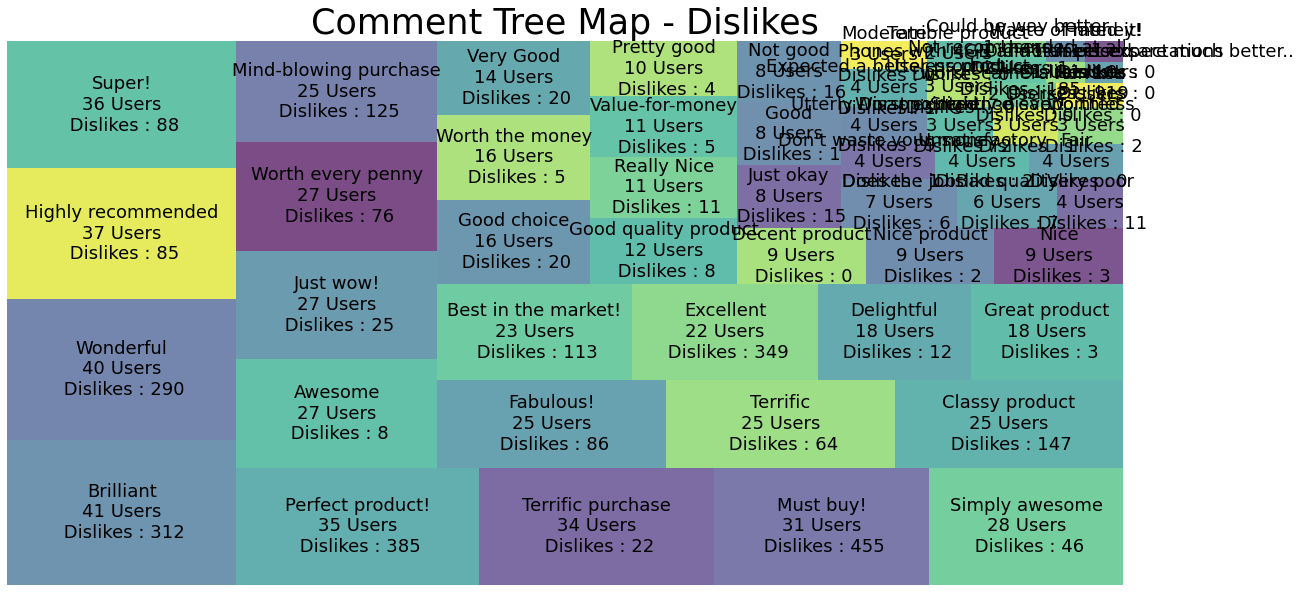

In [117]:
# Brands sorted by number of item
comments = pd.DataFrame(df.Comment.value_counts())
comments.reset_index(level = 0, inplace=True)
comments = comments.sort_values(by='Comment', ascending = False)
comments.columns = ('Comment', 'number_of_item')

# Brands by price
group = df.groupby(df.Comment)
comment_likes = pd.DataFrame(group.Dislikes.sum())
comment_likes.reset_index(level = 0, inplace=True)
# Merging
comments = pd.merge(comments, comment_likes,on='Comment')

# Labels setting
labels = ["%s\n%d Users\n Dislikes : %d" % (label) \
          for label in zip(comments['Comment'], comments['number_of_item'], comments['Dislikes'])]

# Plotting
plt.figure(figsize=(20,10))
plt.rc('font', size=18)
squarify.plot(sizes = comments['number_of_item'], label = labels, alpha = .7)
plt.title('Comment Tree Map - Dislikes', fontsize = 35)
plt.axis('off')

Text(0.5, 0, 'Number of Comments')

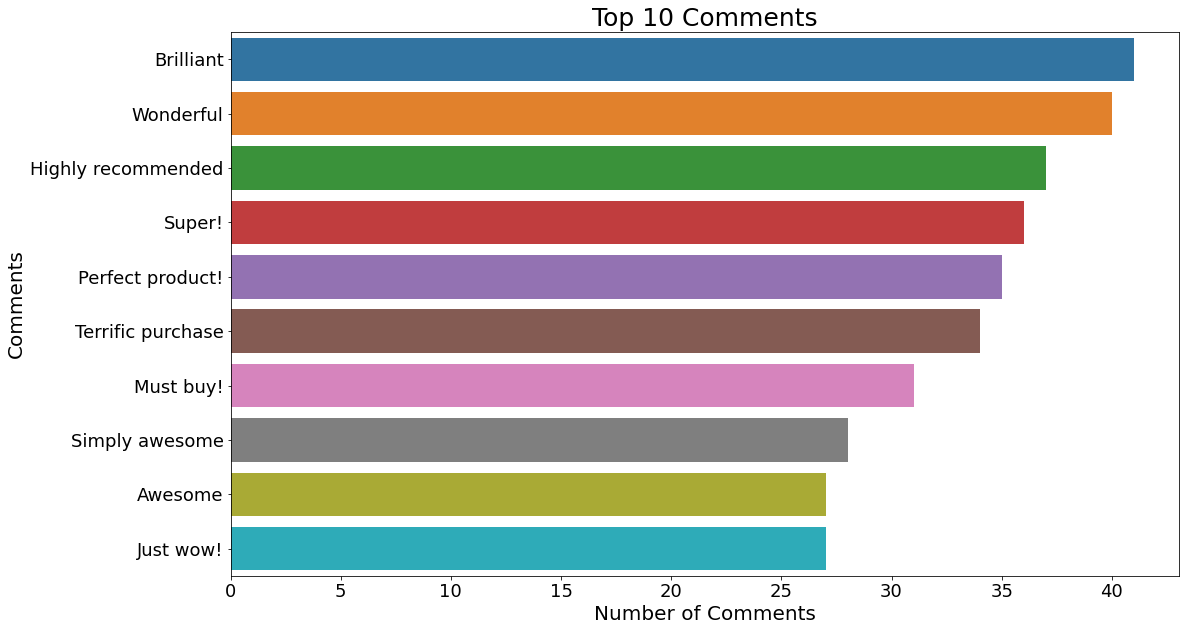

In [118]:
plt.figure(figsize=(17,10))
sns.countplot(y = df.Comment, \
              order = df.Comment.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Top 10 Comments', fontsize = 25)
plt.ylabel('Comments', fontsize = 20)
plt.xlabel('Number of Comments', fontsize = 20)

Text(0.5, 0, 'Count for star rating')

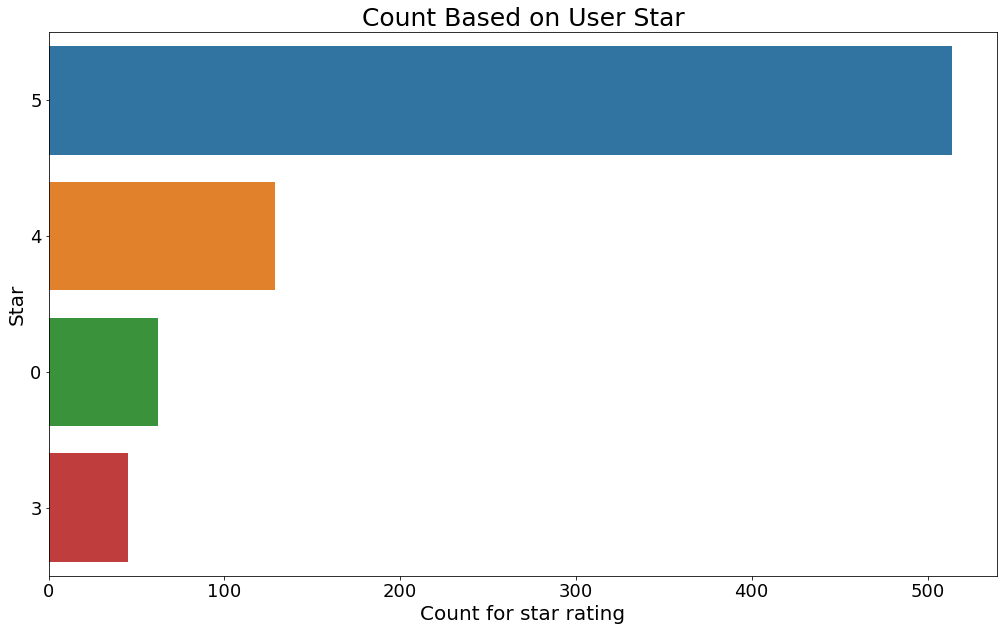

In [121]:
plt.figure(figsize=(17,10))
sns.countplot(y = df.Star, \
              order = df.Star.value_counts().iloc[:10].index, \
                                                      orient = 'v')
plt.title('Count Based on User Star', fontsize = 25)
plt.ylabel('Star', fontsize = 20)
plt.xlabel('Count for star rating', fontsize = 20)

In [123]:
from wordcloud import WordCloud, STOPWORDS

<ipython-input-130-b26a5d080d05>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  exp.name = exp.Comment.str.upper()


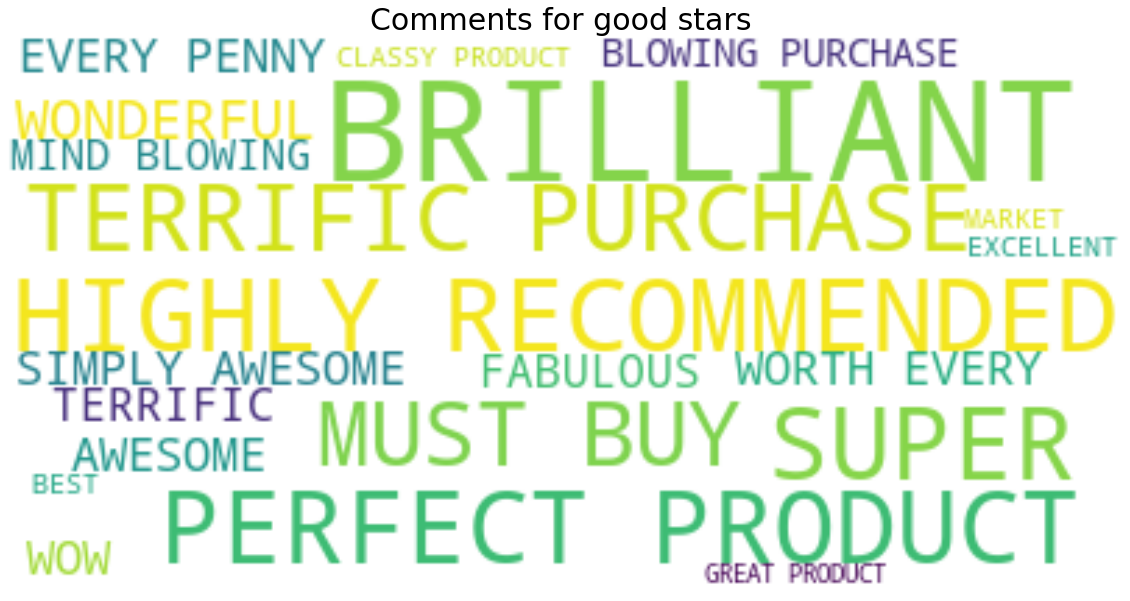

In [130]:
exp = df[df['Star'] > 4]
exp.name = exp.Comment.str.upper()

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)

wc.generate(" ".join(str(s) for s in exp.name.values))

plt.figure(figsize=(20,12))
plt.title('Comments for good stars ', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

<ipython-input-137-28d530465891>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  exp.name = exp.Comment.str.upper()


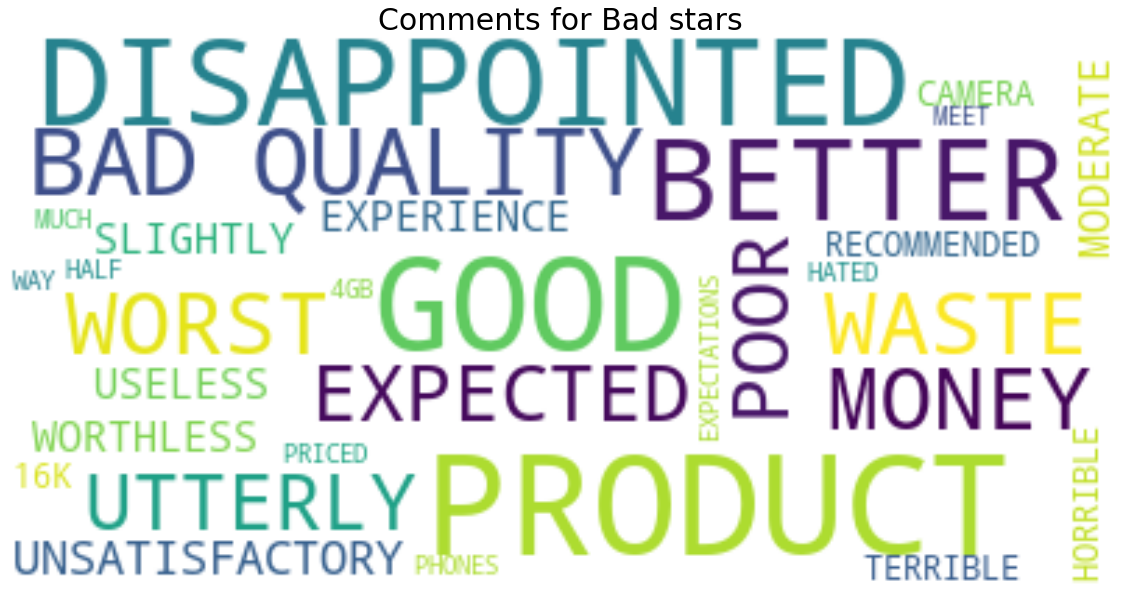

In [137]:
exp = df[df['Star'] <= 1]
exp.name = exp.Comment.str.upper()

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)

wc.generate(" ".join(str(s) for s in exp.name.values))

plt.figure(figsize=(20,12))
plt.title('Comments for Bad stars ', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

In [134]:
!pip install nltk

In [140]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [135]:
import nltk

## Sentence Tokenization

In [146]:
from nltk.tokenize import sent_tokenize
text=df['ReviewSentence']
text=pd.DataFrame(text).to_string()
tokenized_text=sent_tokenize(text)
print(tokenized_text)

['                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           ReviewSentence\n0                                                                                                                                                                                                                                                          Value for money.', 'Front and back Cameras are good for both day and night.', 'Records 4k video in 60 FPS.', 'EIS available for steady video.', 'No heat issues.', 'Battery lasts more than a day.', 'Bokeh mode is superb.', 'Screen resolution

## Word Tokenization

In [145]:
from nltk.tokenize import word_tokenize
tokenized_word=word_tokenize(text)
print(tokenized_word)

['ReviewSentence', '0', 'Value', 'for', 'money', '.', 'Front', 'and', 'back', 'Cameras', 'are', 'good', 'for', 'both', 'day', 'and', 'night', '.', 'Records', '4k', 'video', 'in', '60', 'FPS', '.', 'EIS', 'available', 'for', 'steady', 'video', '.', 'No', 'heat', 'issues', '.', 'Battery', 'lasts', 'more', 'than', 'a', 'day', '.', 'Bokeh', 'mode', 'is', 'superb', '.', 'Screen', 'resolution', 'is', 'sharp', 'and', 'fine', '.', 'Made', 'in', 'India', '.', '1', 'After', 'using', 'Zenfone', '2', 'laser', ',', 'Zenfone', '3', 'Laser', ',', 'Zenfone', 'Deluxe', ',', 'and', 'Zenfone', 'Max', 'Pro', 'M1', 'I', 'planned', 'to', 'buy', 'Z6', 'or', 'Z5', 'but', 'unfortunately', ',', 'Asus', 'phones', 'are', 'not', 'available', 'on', 'Flipkart', 'due', 'to', 'Pandemic', '.', 'I', 'did', 'search', 'for', 'some', 'phones', 'and', 'bought', 'Vivo', '8', 'GB', '/128', 'GB', 'phone', ',', 'trust', 'me', 'Asus', 'Max', 'pro', 'M1', '4Gb', 'phone', 'is', 'much', 'faster', 'and', 'optimized', '.', 'Funtouch'

## Frequency Distribution

In [147]:
from nltk.probability import FreqDist
fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 1591 samples and 4392 outcomes>


In [149]:
fdist.most_common(10)

[('Good', 163),
 ('good', 133),
 ('is', 133),
 ('phone', 120),
 ('Nice', 113),
 ('.', 112),
 ('product', 96),
 ('Very', 67),
 (',', 64),
 ('very', 64)]

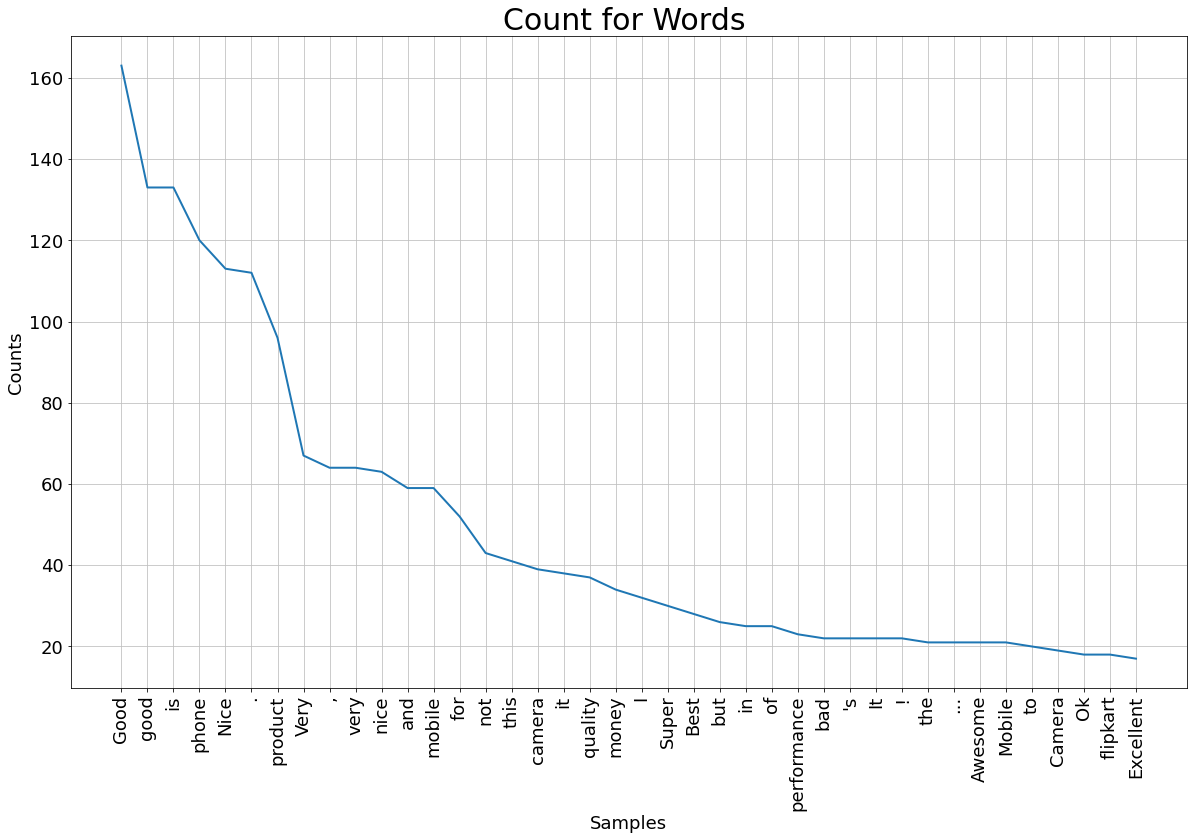

In [158]:
# Frequency Distribution Plot
plt.figure(figsize=(20,12))
plt.title('Count for Words ', fontsize = 30)
fdist.plot(40,cumulative=False)
plt.show()

In [160]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [161]:
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'not', 'when', "you'd", "wasn't", "couldn't", 'at', 'haven', 'herself', 'y', 'here', 'its', 'wouldn', 'again', "hadn't", "she's", 'were', 'did', 'about', 'himself', "weren't", 'whom', "hasn't", 'that', 'so', 'weren', 'in', 'hasn', 'her', 'below', 'was', 'some', 'has', 'having', 'over', 'isn', 'up', 'more', 'a', 'now', 'aren', "you'll", 'he', 'which', 'hadn', 'before', 'does', 'once', 'ours', 'him', 'mightn', 'an', "mustn't", 'won', "wouldn't", 'most', 'am', 'then', 'such', 'just', "didn't", 'for', 'she', 'me', 'we', "aren't", 'only', 'hers', 'yourselves', 'them', 'and', 'few', 'they', 'through', 'no', 'will', 'with', 'until', 'under', 'those', 'to', 'myself', 'from', 'nor', 'yours', 'by', 'while', 'ma', 'mustn', 'above', "that'll", 'the', 'because', 'all', 'you', 'who', 'our', 'have', 'i', 're', 've', 'how', 'down', 'needn', 'out', 'during', 'ain', 'other', 'same', "don't", 'themselves', 'do', 'it', 'very', 'if', 'itself', "haven't", 'or', "shan't", "should've", 'on', 'own', 'between'

In [176]:
df['Reviews'] = df['ReviewSentence'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['Reviews'].head()

0    value for money. front and back cameras are go...
1    after using zenfone 2 laser, zenfone 3 laser, ...
2                                   nice clearity owsm
3                                            very nice
4                   beautyful full and best quality 😘😍
Name: Reviews, dtype: object

In [177]:
df['Reviews'] = df['Reviews'].str.replace('[^\w\s]','')
df['Reviews'].head()

0    value for money front and back cameras are goo...
1    after using zenfone 2 laser zenfone 3 laser ze...
2                                   nice clearity owsm
3                                            very nice
4                     beautyful full and best quality 
Name: Reviews, dtype: object

In [179]:
df['Reviews'] =df['Reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))
df['Reviews'].head()

0    value money front back cameras good day night ...
1    using zenfone 2 laser zenfone 3 laser zenfone ...
2                                   nice clearity owsm
3                                                 nice
4                          beautyful full best quality
Name: Reviews, dtype: object

In [180]:
freq = pd.Series(' '.join(df['Reviews']).split()).value_counts()[:10]
freq

good       297
nice       178
phone      128
product    101
mobile      78
camera      58
quality     42
super       40
best        39
money       35
dtype: int64

In [181]:
freq = pd.Series(' '.join(df['Reviews']).split()).value_counts()[-10:]
freq

fabulous     1
little       1
lastly       1
lot          1
rhis         1
pricelove    1
quilts       1
less         1
else         1
miss         1
dtype: int64

In [182]:
freq = list(freq.index)
df['Reviews'] = df['Reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
df['Reviews'].head()

0    value money front back cameras good day night ...
1    using zenfone 2 laser zenfone 3 laser zenfone ...
2                                   nice clearity owsm
3                                                 nice
4                          beautyful full best quality
Name: Reviews, dtype: object

In [184]:
!pip install -U textblob

In [185]:
from textblob import TextBlob
df['Reviews'][:5].apply(lambda x: str(TextBlob(x).correct()))

0    value money front back camera good day night r...
1    using zenfone 2 laser zenfone 3 laser zenfone ...
2                                     nice clarity own
3                                                 nice
4                          beautiful full best quality
Name: Reviews, dtype: object

In [186]:
TextBlob(df['Reviews'][1]).words

WordList(['using', 'zenfone', '2', 'laser', 'zenfone', '3', 'laser', 'zenfone', 'deluxe', 'zenfone', 'max', 'pro', 'm1', 'planned', 'buy', 'z6', 'z5', 'unfortunately', 'asus', 'phones', 'available', 'flipkart', 'due', 'pandemic', 'search', 'phones', 'bought', 'vivo', '8', 'gb', '128', 'gb', 'phone', 'trust', 'asus', 'max', 'pro', 'm1', '4gb', 'phone', 'much', 'faster', 'optimized', 'funtouch', 'os', 'scrape', 'professional', 'want', 'work', 'profile', 'phone', 'go', 'stock', 'android', 'worst', 'part', 'vivo', 'support', 'widgets', 'like', 'slack'])

In [187]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
df['Reviews'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0    valu money front back camera good day night re...
1    use zenfon 2 laser zenfon 3 laser zenfon delux...
2                                   nice cleariti owsm
3                                                 nice
4                             beauty full best qualiti
Name: Reviews, dtype: object

In [188]:
from textblob import Word
df['Reviews'] = df['Reviews'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Reviews'].head()

0    value money front back camera good day night r...
1    using zenfone 2 laser zenfone 3 laser zenfone ...
2                                   nice clearity owsm
3                                                 nice
4                          beautyful full best quality
Name: Reviews, dtype: object

In [189]:
TextBlob(df['Reviews'][0]).ngrams(2)

[WordList(['value', 'money']),
 WordList(['money', 'front']),
 WordList(['front', 'back']),
 WordList(['back', 'camera']),
 WordList(['camera', 'good']),
 WordList(['good', 'day']),
 WordList(['day', 'night']),
 WordList(['night', 'record']),
 WordList(['record', '4k']),
 WordList(['4k', 'video']),
 WordList(['video', '60']),
 WordList(['60', 'fps']),
 WordList(['fps', 'eis']),
 WordList(['eis', 'available']),
 WordList(['available', 'steady']),
 WordList(['steady', 'video']),
 WordList(['video', 'heat']),
 WordList(['heat', 'issue']),
 WordList(['issue', 'battery']),
 WordList(['battery', 'last']),
 WordList(['last', 'day']),
 WordList(['day', 'bokeh']),
 WordList(['bokeh', 'mode']),
 WordList(['mode', 'superb']),
 WordList(['superb', 'screen']),
 WordList(['screen', 'resolution']),
 WordList(['resolution', 'sharp']),
 WordList(['sharp', 'fine']),
 WordList(['fine', 'made']),
 WordList(['made', 'india'])]

In [190]:
tf1 = (df['Reviews'][1:2]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
tf1.columns = ['words','tf']
tf1

,words,tf
0,phone,5
1,zenfone,4
2,laser,2
3,max,2
4,asus,2
5,m1,2
6,gb,2
7,pro,2
8,vivo,2
9,worst,1


In [191]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(df.shape[0]/(len(df[df['Reviews'].str.contains(word)])))

tf1

,words,tf,idf
0,phone,5,1.799792
1,zenfone,4,6.620073
2,laser,2,6.620073
3,max,2,6.620073
4,asus,2,6.620073
5,m1,2,5.926926
6,gb,2,5.233779
7,pro,2,1.840950
8,vivo,2,3.252777
9,worst,1,5.010635


In [192]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1

,words,tf,idf,tfidf
0,phone,5,1.799792,8.998958
1,zenfone,4,6.620073,26.480293
2,laser,2,6.620073,13.240146
3,max,2,6.620073,13.240146
4,asus,2,6.620073,13.240146
5,m1,2,5.926926,11.853852
6,gb,2,5.233779,10.467558
7,pro,2,1.840950,3.681899
8,vivo,2,3.252777,6.505555
9,worst,1,5.010635,5.010635


In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
train_vect = tfidf.fit_transform(df['Reviews'])

train_vect

<750x546 sparse matrix of type '<class 'numpy.float64'>'
	with 2135 stored elements in Compressed Sparse Row format>

In [194]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(df['Reviews'])
train_bow

<750x582 sparse matrix of type '<class 'numpy.int64'>'
	with 2219 stored elements in Compressed Sparse Row format>

In [195]:
df['Reviews'][:5].apply(lambda x: TextBlob(x).sentiment)

0     (0.31979166666666664, 0.4770833333333333)
1    (-0.04642857142857144, 0.5678571428571428)
2                                    (0.6, 1.0)
3                                    (0.6, 1.0)
4                  (0.675, 0.42500000000000004)
Name: Reviews, dtype: object

In [196]:
df['sentiment'] =df['Reviews'].apply(lambda x: TextBlob(x).sentiment[0] )
df[['Reviews','sentiment']].head()

,Reviews,sentiment
0,value money front back camera good day night r...,0.319792
1,using zenfone 2 laser zenfone 3 laser zenfone ...,-0.046429
2,nice clearity owsm,0.600000
3,nice,0.600000
4,beautyful full best quality,0.675000


In [197]:
df.head()

,User,Comment,Star,ReviewSentence,Likes,Dislikes,UserName,Reviews,sentiment
0,"Ganesh GandhiCertified Buyer, Villupuram5 mont...",Mind-blowing purchase,5,Value for money. Front and back Cameras are g...,508,119,Ganesh,value money front back camera good day night r...,0.319792
1,"ShreeksCertified Buyer, Bangalore9 months ago2...",Phones with 4GB and half priced are much better..,0,"After using Zenfone 2 laser, Zenfone 3 Laser, ...",2294,919,ShreeksCertified,using zenfone 2 laser zenfone 3 laser zenfone ...,-0.046429
2,"Ajay PadmaCertified Buyer, Pune5 months ago36...",Fabulous!,5,Nice clearity owsm,366,38,Ajay,nice clearity owsm,0.600000
3,"pramod pramodCertified Buyer, East Godavari Di...",Best in the market!,5,Very nice,631,99,pramod,nice,0.600000
4,"Aftab HCertified Buyer, Tiruppur8 months ago15...",Perfect product!,5,beautyful full and best quality 😘😍,1598,302,Aftab,beautyful full best quality,0.675000


<ipython-input-221-e1a6ab9f4375>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  exp.name = exp.Comment.str.upper()


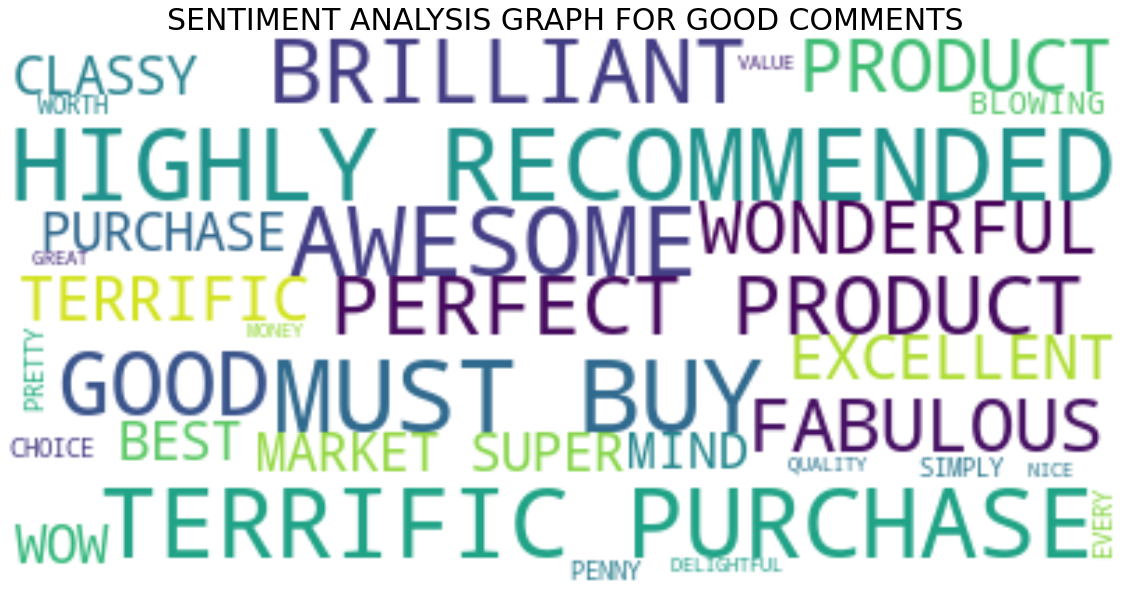

In [221]:
exp = df[df['sentiment'] > 0.7 ]
exp.name = exp.Comment.str.upper()

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)

wc.generate(" ".join(str(s) for s in exp.name.values))

plt.figure(figsize=(20,12))
plt.title('SENTIMENT ANALYSIS GRAPH FOR GOOD COMMENTS', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')

<ipython-input-242-0ad46160d905>:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  exp.name = exp.Comment.str.upper()


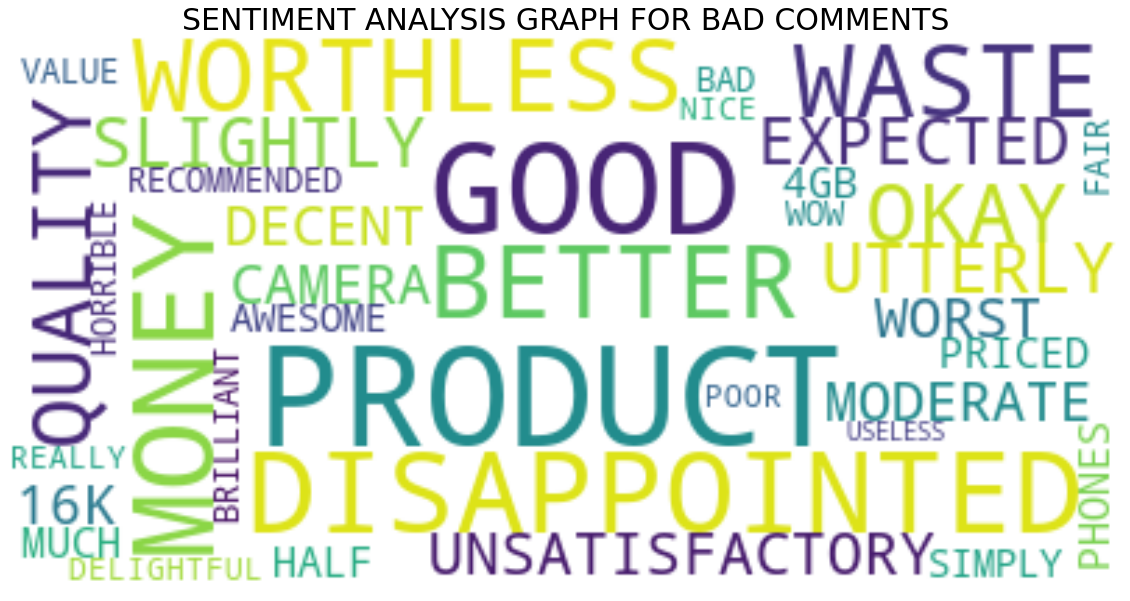

In [242]:
exp = df[df['sentiment'] < -0.01]
exp.name = exp.Comment.str.upper()

wc = WordCloud(background_color="white", max_words=5000, 
               stopwords=STOPWORDS, max_font_size= 50)

wc.generate(" ".join(str(s) for s in exp.name.values))

plt.figure(figsize=(20,12))
plt.title('SENTIMENT ANALYSIS GRAPH FOR BAD COMMENTS', fontsize = 30)
plt.axis('off')
plt.imshow(wc, interpolation='bilinear')